## Read in JCMB weather station data

                           pres  rain    windsp      windir      airT  \
date                                                                    
2012-01-01 00:00:00  993.250000   0.0  7.169429  191.896429  8.514643   
2012-01-01 00:30:00  993.033333   0.0  7.822333  189.363333  8.013333   
2012-01-01 01:00:00  992.133333   0.0  8.757833  181.953333  7.746333   
2012-01-01 01:30:00  993.100000   0.0  7.436467  219.466667  7.558667   
2012-01-01 02:00:00  993.000000   0.0  6.842833  209.400000  7.945333   

                            rh     solar      battV  
date                                                 
2012-01-01 00:00:00  70.709643  0.000000  13.780000  
2012-01-01 00:30:00  75.630000  0.197307  13.794000  
2012-01-01 01:00:00  77.213333  0.246633  13.806000  
2012-01-01 01:30:00  76.426667  1.529127  13.810333  
2012-01-01 02:00:00  76.360000  0.197307  13.814000  


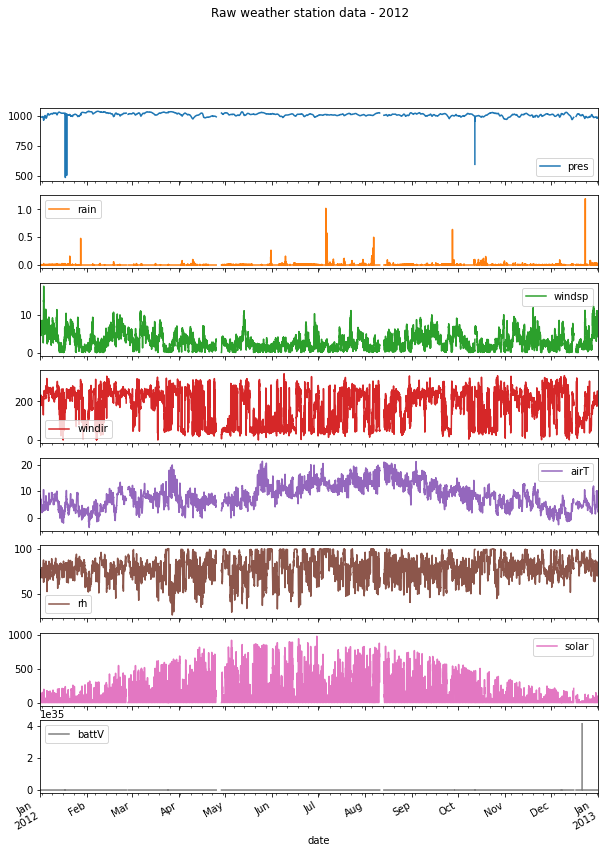

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt
import pysolar
import pytz
inpath = ""

# About:
# script to read in a weather station file from JCMB
# and calculate the ratio of observed to modelled solar radiation
# so that relative cloudiness can be estimated

# Version 0.1   JBM  22 Feb 2020
# Latest: 20:00  28 March 2020

# Enter the year you want to work on below
year = 2012

infilename = inpath+"JCMB_"+str(year)+".csv"

df = pd.read_csv(infilename, sep=",", skiprows=2, header=None,
                     names=['date-time', 'pres', 'rain', 'windsp', 'windir',
                            'airT', 'rh', 'solar', 'battV'])

#################################################
# A peculiarity of the JCMB weather station data is that
# midnight is recorded as 24:00 on the preceding day
# eg 2006/05/01 24:00  should be 2006/05/02 00:00
# This is not compatible with the python %H parameter (which only goes from 0 to 23)
# so we need to edit the raw data file first
# Solution proposed here: https://stackoverflow.com/questions/52688645/

# find datetimes which have '24:00' and rewrite
df['datetime_zero'] = df['date-time'].str.replace('24:00','0:00')

df['datetime_er'] = pd.to_datetime(df['datetime_zero'], format='%Y/%m/%d %H:%M')
selrow = df['date-time'].str.contains('24:00')
df['date-time1'] = df['datetime_er'] + selrow * timedelta(days=1)
df['date'] = pd.to_datetime(df['date-time1'], format='%Y/%m/%d %H:%M')
df.set_index('date', inplace=True)
df['solar'] *= 1000  # convert to W m-2

startTime = pd.to_datetime(df.index[0])
timezone = pytz.timezone('Europe/London')
endTime = pd.to_datetime(df.index[-1])

df = df.resample('30T').mean()
print(df.head())
# Just have a look at all the raw data first
ax=df.plot(subplots=True, figsize=(10, 14), title='Raw weather station data'+' - '+str(year))
#fig.tight_layout()
#fig.subplots_adjust(top=0.95)
plt.show()

## Now calculate max potential hourly solar radiation at JCMB

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fad7c242510>],
      dtype=object)

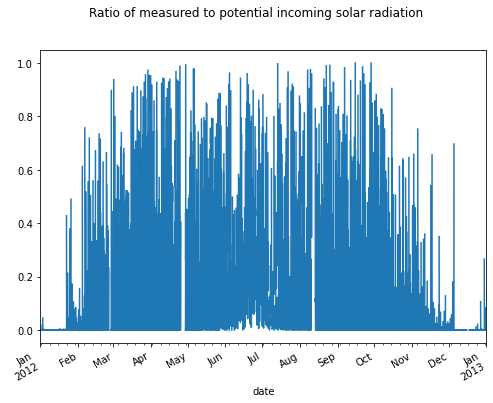

In [2]:
# https://earthscience.stackexchange.com/questions/14491/how-to-calculate-the-solar-radiation-at-any-place-any-time
lat, lon = 55.913168, -3.159998  # JCMB, KB, Edinburgh  (Liberton at the mo)
# Calculate radiation every hour in the year currently selected
maxrad = list()
r, c = df.shape    # how many rows and columns are in the original dataframe?

for ihr in range(0, r):
    date = startTime + dt.timedelta(hours=ihr)
    date = timezone.localize(date)
    altitude_deg = pysolar.solar.get_altitude(lat, lon, date)
    if altitude_deg <= 0:
        smax = 0.
    else:
        smax = pysolar.radiation.get_radiation_direct(date, altitude_deg)
    maxrad.append(smax)

# add the new list to the existing dataframe
df['maxs'] = maxrad
df['sratio'] = df['solar']/df['maxs']
# some sratios > 1 exist so get rid of them
df.loc[df['sratio'] > 1, 'sratio'] = np.NAN

df['sratio'].plot(subplots=True, figsize=(8,6), title='Ratio of measured to potential incoming solar radiation')


## Repeat for a specific time interval

<function matplotlib.pyplot.show(*args, **kw)>

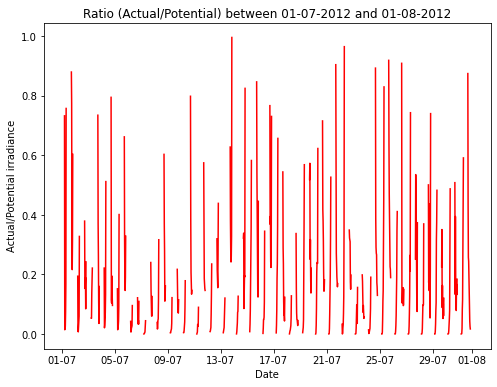

In [3]:
starttime = dt.datetime.strptime('2012-07-01', '%Y-%m-%d')
endtime = dt.datetime.strptime('2012-08-01', '%Y-%m-%d')
mask = (df.index > starttime) & (df.index <= endtime)
#print(df.loc[mask])
df1 = df.loc[mask]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df1.index, df1['sratio'], color='red')
ax.set(xlabel='Date',ylabel='Actual/Potential irradiance',
       title='Ratio (Actual/Potential) between '
       + dt.datetime.strftime(starttime, '%d-%m-%Y') +' and '
       + dt.datetime.strftime(endtime, '%d-%m-%Y'))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show

## Now read in METAR data from Edinburgh Airport (code EGPH)

  station             valid  tpc  dwpc   relh   drct  sped  skyc1
0    EGPH  01/01/2011 01:20  6.0   5.0  93.30  250.0  4.60    3.0
1    EGPH  01/01/2011 01:50  6.0   5.0  93.30  250.0  5.75    2.0
2    EGPH  01/01/2011 02:20  6.0   5.0  93.30  260.0  3.45    2.0
3    EGPH  01/01/2011 02:50  5.0   4.0  93.24    NaN  3.45    2.0
4    EGPH  01/01/2011 03:20  5.0   4.0  93.24    NaN  2.30    0.0
                     tpc  dwpc   relh   drct  sped  skyc1
valid                                                    
2011-01-01 01:00:00  6.0   5.0  93.30  250.0  4.60    3.0
2011-01-01 01:30:00  6.0   5.0  93.30  250.0  5.75    2.0
2011-01-01 02:00:00  6.0   5.0  93.30  260.0  3.45    2.0
2011-01-01 02:30:00  5.0   4.0  93.24    NaN  3.45    2.0
2011-01-01 03:00:00  5.0   4.0  93.24    NaN  2.30    0.0


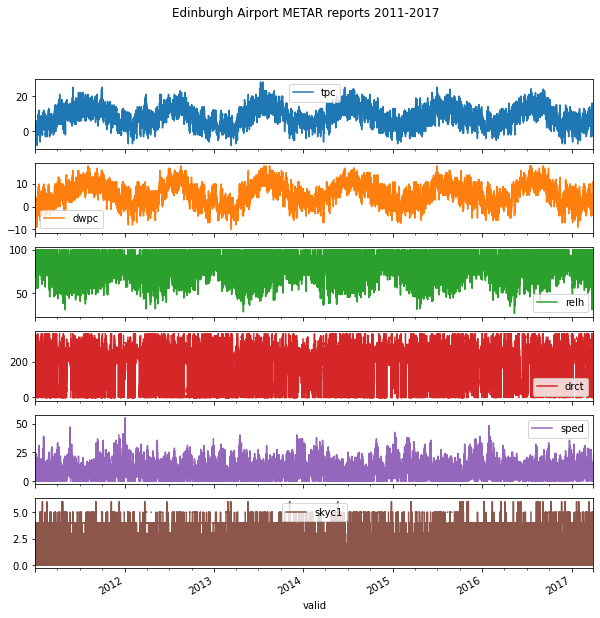

In [4]:
import pandas as pd
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta

from numpy import float32
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
inpath = ''

# Get the name of the input file with raw weather data from JCMB
infilename = inpath+'EGPH_2011_2017.csv'
headers = ['station', 'valid', 'tpc', 'dwpc', 'relh', 'drct', 'sped', 'skyc1']
# types = {'station': 'str', 'valid': 'str', 'tmpc': 'float', 'dwpc': 'float', 'relh' : 'float', 'drct' : 'float',
#          'sped': 'float', 'skyc1': 'str'}

### Had to clean up the original data file since there's a mixture of numbers and strings (in skyc1 column)
###  and Pandas only takes one type of object at a time ie all numbers OR all strings etc but not both.
### So - replaced the skycn code with an integer number as follows:
### few = 0, skt = 1, bkn = 2, ovc = 3, ncd = 4, nsc = 5, VV = 6
### where the following Table converts to oktas of cloud cover:
###   Abbreviation   Oktas          Code used in skyc1 column
###      few         1-2                0
###      skt         3-4                1
###      bkn         5-7                2
###      ovc         8                  3
###      ncd         no cloud detcd     4
###      nsc         nil cloud          5
###      VV          cannot see cloud   6
###                    ie fog
### see: https://en.wikipedia.org/wiki/METAR#International_METAR_codes

df3 = pd.read_csv(infilename, sep=',', skiprows=6, header=None, names=headers)  # dtype=types)
print(df3.head())
# Make the timestamp the index for the file
df3['valid'] = pd.to_datetime(df3['valid'], format='%d/%m/%Y %H:%M')
df3.set_index('valid', inplace=True)
# Take the mean over 30 minutes ie 30T 
# but note that observations are at 20 minutes past the hour and 10 minutes to - so need to fix this.
df3=df3.resample('30T').mean()
print(df3.head())
# Put all the data into ONE big plot
df3.plot(subplots=True, figsize=(10, 10), title = 'Edinburgh Airport METAR reports 2011-2017')
plt.show()

## Just plot sky conditions - (plotting as codes 0 = few, 1 = skt etc)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fad68d55dd0>],
      dtype=object)

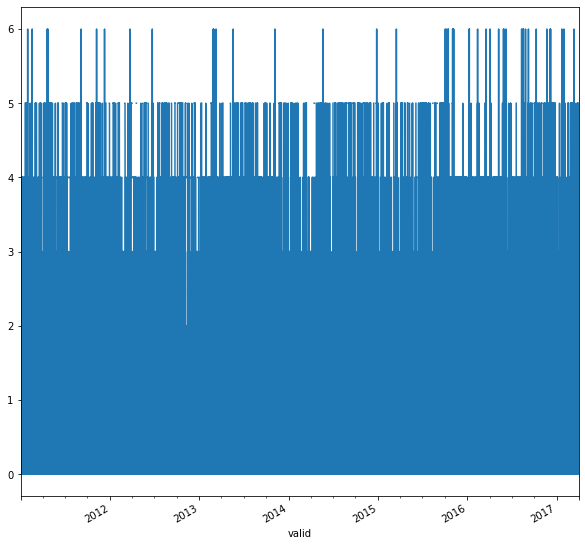

In [5]:
df3['skyc1'].plot(subplots=True, figsize=(10, 10))


<function matplotlib.pyplot.show(*args, **kw)>

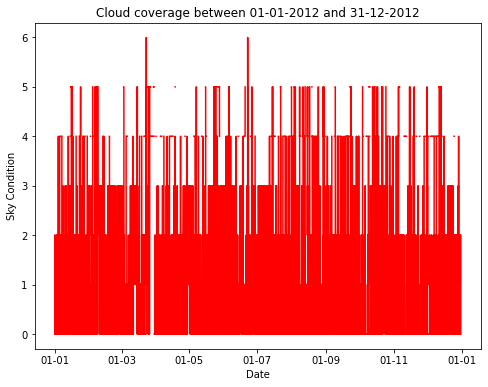

In [6]:
# Now just plot a year's worth of data so we can compare with JCMB data above
starttime = dt.datetime.strptime('2012-01-01', '%Y-%m-%d')
endtime = dt.datetime.strptime('2012-12-31', '%Y-%m-%d')
mask = (df3.index > starttime) & (df3.index <= endtime)
#print(df.loc[mask])
df4 = df3.loc[mask]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df4.index, df4['skyc1'], color='red')
ax.set(xlabel='Date',ylabel='Sky Condition',
       title='Cloud coverage between '
       + dt.datetime.strftime(starttime, '%d-%m-%Y') +' and '
       + dt.datetime.strftime(endtime, '%d-%m-%Y'))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show


## Plot the ratio of observed/modelled vs the sky condition - what do we see?
## Hypothesis is that high ratios should correspond with skyc1 around 0 or 1
## and low ratio should be in overcast conditions ie skyc1 around 2 or 3

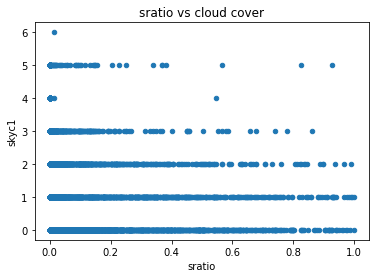

In [7]:
# Need to merge the ratio and skyc1 dataframes first based on time index
# merge across columns
df5 = pd.concat([df['sratio'], df4['skyc1']], axis=1)

df5.plot.scatter(x='sratio', y='skyc1', title='sratio vs cloud cover')
# remember these are the codes
###   Abbreviation   Oktas          Code used in skyc1 column
###      few         1-2                0
###      skt         3-4                1
###      bkn         5-7                2
###      ovc         8                  3
###      ncd         no cloud detcd     4
###      nsc         nil cloud          5
###      VV          cannot see cloud   6
###                    ie fog

## Now need to convert the codes into stability index per half hour

## Base it on the Pasquill dispersion classes

<img src="img/Pasquill_classes.png" width="560" height="460">

In [8]:
#  
A_query_index = df.query('windsp< 2.0 & solar >500').index
print(A_query_index,1)
df.loc[A_query_index] = 1

# can't store a string, use a code instead: A =  1 etc

# df['stability']
#
#

DatetimeIndex(['2012-03-22 10:30:00', '2012-03-22 11:00:00',
               '2012-03-22 11:30:00', '2012-03-22 12:30:00',
               '2012-03-22 13:00:00', '2012-03-23 13:00:00',
               '2012-03-23 13:30:00', '2012-03-25 11:00:00',
               '2012-03-25 11:30:00', '2012-03-25 12:30:00',
               ...
               '2012-08-30 13:00:00', '2012-08-30 14:00:00',
               '2012-09-21 11:00:00', '2012-09-21 11:30:00',
               '2012-09-22 11:00:00', '2012-09-22 11:30:00',
               '2012-09-22 12:30:00', '2012-09-22 13:00:00',
               '2012-10-06 12:30:00', '2012-10-15 13:30:00'],
              dtype='datetime64[ns]', name='date', length=344, freq=None) 1
